In [4]:
# !pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
downloaded = drive.CreateFile({'id':'1-Hh3pdJlxhHWy42ZqXFDdjjBxe4vhoRg'})
downloaded.GetContentFile('train.csv') 

# Base Model


## Importing relevant libraries


In [1]:
import json
import keras
import pandas as pd
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Dropout, Activation, Embedding
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

import json
from keras.models import model_from_json

# Import libraries
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
# nltk.download()
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)

import string
import re

Using TensorFlow backend.


## Exploring data


In [4]:
data = pd.read_csv('./nlp-getting-started/train.csv', encoding='utf-8')
# Only alter the training variable (#never alter the data variable itself)
pd.set_option('display.max_rows', None)
data.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charge...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


### Analysis
- there are 7613 data points
- **99.198739%** of the data has **keywords**
- **66.73%** of the data has **location** points
- the top key word used to extract tweets is **fatalities**
- data is ordered in terms of keyword used to extact the tweet from twitter 
- therefore shuffle the data to mix it.
- some of the data contains the # symbol which causes an error when the data is exported onto a numpy array
- elements in the **text** column which does not have " " marks should not include **,** 
- data in the **location** column may also include **,** marks which will be read as a column delimeter by **np**

### Decisions 

- the most important columns are the text and target columns
- the text column contains information about the tweet
- the keyword column can be discarded because the keyword appears within the tweet itself.
- the location column can be discarded because only 66.73% have a location value associated with them. Droping 33% of the data is impractical
- it is however worth exploring whether location of tweet has an impact on the real or fake status of a tweet

- in some locations such as a city centre there cannot be a veld fire - so that is a consideration to be made


### Data cleaning

In [5]:
#### removing entries where location values are missing
data_after_null_removal = data.copy()
# data_after_null_removal = data_after_null_removal.dropna(subset=['location'])

#punctutation removal
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

data_afer_punctuation_removal = data_after_null_removal.copy()
data_afer_punctuation_removal['text'] = data_afer_punctuation_removal['text'].apply(lambda x: clean_text(x))
data_afer_punctuation_removal.head(10)

# Tockenization

def tokenization(text):
    text = re.split('\W+', text)
    return text

tockenized_data = data_afer_punctuation_removal.copy()
tockenized_data['text'] = tockenized_data['text'].apply(lambda x: tokenization(x.lower()))

# stopword removal 
data_after_stopword_removal = tockenized_data.copy()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

data_after_stopword_removal['text'] = data_after_stopword_removal['text'].apply(lambda x: remove_stopwords(x))

# return to string
data_without_tockenization = data_after_stopword_removal.copy()
def listToString(s):     
    # initialize an empty string 
    str1 = " " 
    # return string   
    return (str1.join(s)) 
        
data_without_tockenization['text'] = data_without_tockenization['text'].apply(lambda x: listToString(x))
data_without_tockenization

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officers evacuation shelter place orders expected,1
3,6,NaN,NaN,people receive wildfires evacuation orders california,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pours school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse nearby homes,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires california even northern part state troubling,1
7610,10871,NaN,NaN,volcano hawaii,1
7611,10872,NaN,NaN,police investigating ebike collided car little portugal ebike rider suffered serious nonlife thr...,1


In [6]:
### train - test split
training, testing = train_test_split(data_without_tockenization, test_size=0.1, random_state=42, shuffle=True)

In [7]:
train = training.copy()
test = testing.copy()
# get the dependent and independent variables
train_x = train['text']
train_y = train['target']
test_x = test['text']
test_y = test['target']

## Preprocessing


In [6]:
train_x = np.array(train_x)
train_y = np.array(train_y)


# only work with the 3000 most popular words found in our dataset
max_words = 10000

# create a new Tokenizer
tokenizer = Tokenizer(num_words=max_words)
# feed our tweets to the Tokenizer
tokenizer.fit_on_texts(train_x)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

# Saving the dictionary
with open('./Dictionary_Models/dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)

# padding tockenized text so that it is all the same length(longest word's length).
def convert_text_to_index_array(text):
    return [dictionary[word] for word in kpt.text_to_word_sequence(text)]

allWordIndices = []
# for each tweet, change each token to its ID in the Tokenizer's word_index
for text in train_x:
    wordIndices = convert_text_to_index_array(text)
    allWordIndices.append(wordIndices)

#array of tweets as indeces(words replaced with indexes)
allWordIndices = np.asarray(allWordIndices)

# create one-hot matrices out of the indexed tweets
train_x = tokenizer.sequences_to_matrix(allWordIndices, mode='binary')
# treat the labels as categories
train_y = keras.utils.to_categorical(train_y, 2)

## Model


In [20]:
model = Sequential()
model.add(Dense(512, input_shape=(max_words,), activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(512, activation='sigmoid'))
# model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy','Precision','Recall'])


history = model.fit(train_x, train_y,
    batch_size=16,
    epochs=10,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
    callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
)

model_json = model.to_json()
with open('./NN_Models/base_model.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('./NN_Models/base_model.h5')

print('saved model!')


Epoch 1/10
386/386 [==============================] - 18s 45ms/step - loss: 0.5376 - accuracy: 0.7273 - precision: 0.7273 - recall: 0.7273 - val_loss: 0.4491 - val_accuracy: 0.8090 - val_precision: 0.8090 - val_recall: 0.8090
Epoch 2/10
386/386 [==============================] - 15s 40ms/step - loss: 0.2578 - accuracy: 0.9019 - precision: 0.9019 - recall: 0.9019 - val_loss: 0.5378 - val_accuracy: 0.7872 - val_precision: 0.7872 - val_recall: 0.7872
Epoch 00002: early stopping
saved model!


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


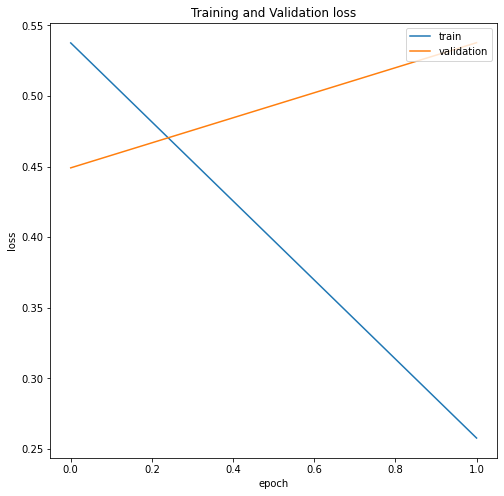

In [21]:
print(history.history.keys())
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Testing Model


In [23]:
# we're still going to use a Tokenizer here, but we don't need to fit it
tokenizer = Tokenizer(num_words=10000)
# for human-friendly printing
labels = ['fake', 'real']

# read in our saved dictionary
with open('./Dictionary_Models/dictionary.json', 'r') as dictionary_file:
    dictionary = json.load(dictionary_file)

def convert_text_to_index_array(text):
    words = kpt.text_to_word_sequence(text)
    wordIndices = []
    for word in words:
        if word in dictionary:
            wordIndices.append(dictionary[word])

    return wordIndices

# read in your saved model structure
json_file = open('./NN_Models/base_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# and create a model from that
model = model_from_json(loaded_model_json)
# and weight your nodes with your saved values
model.load_weights('./NN_Models/base_model.h5')

predictions = []

for index_of_interest, text1 in enumerate(test_x):
    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
    # predict which bucket your input belongs in

    # format your input for the neural net
    testArr = convert_text_to_index_array(text1)
    input = tokenizer.sequences_to_matrix([testArr], mode='binary')
        # predict which bucket your input belongs in
    pred = model.predict(input)

    predictions.append(np.argmax(pred))


In [24]:

predictions = np.array(predictions)
test_y = np.array(test_y)
confusion_matrix(test_y, predictions)

tn, fp, fn, tp = confusion_matrix(test_y, predictions).ravel()
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tn + fp +fn +tp)
falsePositiveRate = fp / (fp + tn)
recall = tp/(tp+fn)
f1_score = 2 * ((recall*precision)/(recall+precision))

# Intialise data to Dicts of series. 
d = {'Value' : pd.Series([accuracy, precision, falsePositiveRate, recall,f1_score], index =['Accuracy', 'Precision', 'FPR','Recall','F1'])} 
  
# creates Dataframe. 
results = pd.DataFrame(d) 
  

data = {'Negative':[tn, fn], 'Positive':[fp, tp]} 
  
# Creates pandas DataFrame. 
df = pd.DataFrame(data, index =['Negative', 'Positive']) 
df

,Negative,Positive
Negative,361,65
Positive,110,226


In [25]:
results

,Value
Accuracy,0.770341
Precision,0.776632
FPR,0.152582
Recall,0.672619
F1,0.720893


### Summary of Base model
- The highest achievable accuracy is 77%
- The best FPR is 0.09
- Model starts overfitting from the first epoch
- Validation loss never goes below ~0.45
- Attempts were made to vary the batch size. Large batch sizes yield worse performance. The best performance is at 32 or 16
- Increasing the number of layers also results in worse performance. Less layers produce better performance
- Drop out layers make little to no difference in performance
- Including tweets without the keyword seems to yield better performance
- Data cleaning produced a slightly less validation loss but not significant enough